<a href="https://colab.research.google.com/github/ronaldbmz/stable_diffusion/blob/main/stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic setup

## Installations

In [ ]:
!pip install -Uq diffusers transformers fastcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 50.9 MB/s eta 0:00:00


## Imports

In [ ]:
from huggingface_hub import notebook_login, login
from google.colab import userdata

import logging, math
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline

from fastcore.all import concat
from fastdownload import FastDownload

logging.disable(logging.WARNING)

torch.manual_seed(1)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Utils

In [ ]:
def image_grid(imgs, rows=1, cols=None):
    if cols is None: cols = math.ceil(len(imgs)/rows)
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Hugging Face access token

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work.

In [ ]:
#if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

In [ ]:
login(token=userdata.get('HF_TOKEN'))

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Stable Diffusion Inference (Text to Image)

## Load pipeline

Download the pretrained weights. Use the `fp16` (half-precision) version of the weights which allows us to perform much faster inference with almost no discernible difference in quality.

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", variant="fp16", torch_dtype=torch.float16).to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
!ls ~/.cache/huggingface/hub

models--CompVis--stable-diffusion-v1-4	version_diffusers_cache.txt  version.txt


If your GPU is not big enough to use `pipe`, run `enable_attention_slicing`. When this option is enabled, the attention module will split the input tensor in slices, to compute attention in several steps. This is useful to save some memory in exchange for a small speed decrease.

In [ ]:
#pipe.enable_attention_slicing()

## Make inference

In [ ]:
prompt = "a photograph of an astronaut riding a horse"
imgs = pipe(prompt).images

  0%|          | 0/50 [00:00<?, ?it/s]

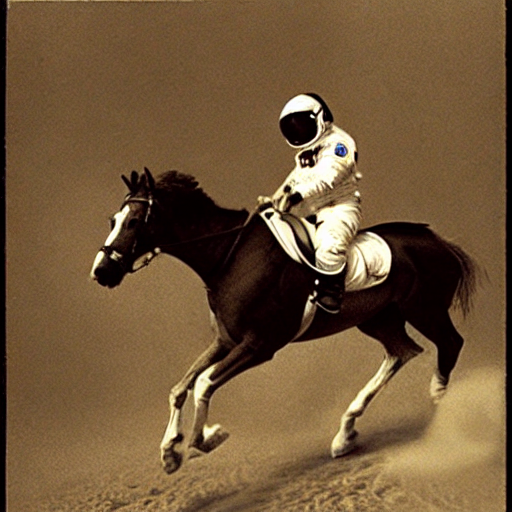

In [ ]:
imgs[0]

# Stable Diffusion Inference (Image to Image)

Instead of starting from pure noise, we start from an image and add a certain amount of noise to it. That is, we remove the initial steps of the denoising and pretend that our image is what the algorithm came up with by the end of those initial steps. Then we continue the diffusion process as usual.

## Load pipeline

In [ ]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", variant="fp16", torch_dtype=torch.float16).to("cuda")
#pipe.enable_attention_slicing()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Load initial image

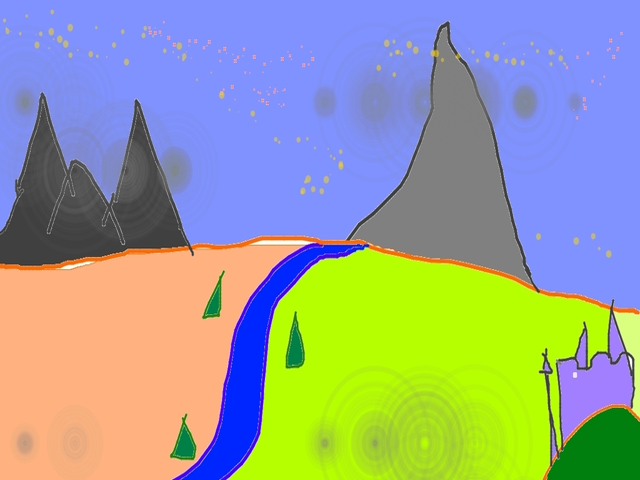

In [ ]:
im = FastDownload().download("https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg")
init_image = Image.open(im).convert('RGB').resize((640, 480))
init_image

## Edit image

In [ ]:
prompt = "A fantasy landscape, trending on artstation"
imgs = pipe(prompt=prompt, image=init_image, num_images_per_prompt=3, strength=0.75, num_inference_steps=100, guidance_scale=7.5).images

  0%|          | 0/75 [00:00<?, ?it/s]

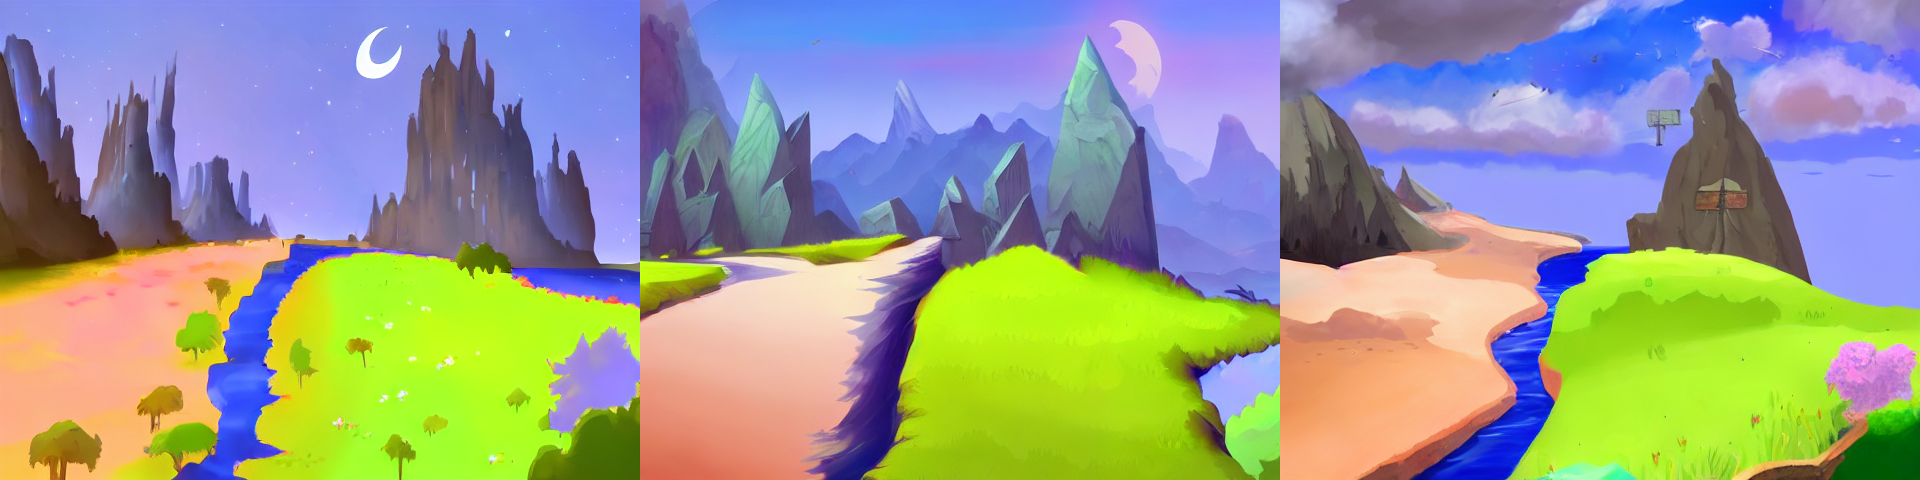

In [ ]:
image_grid(imgs, rows=1)

In [ ]:
prompt = "A fantasy landscape, photorealistic"
imgs = pipe(prompt=prompt, image=imgs[1], num_images_per_prompt=1, strength=1, num_inference_steps=100, guidance_scale=7.5).images

  0%|          | 0/100 [00:00<?, ?it/s]

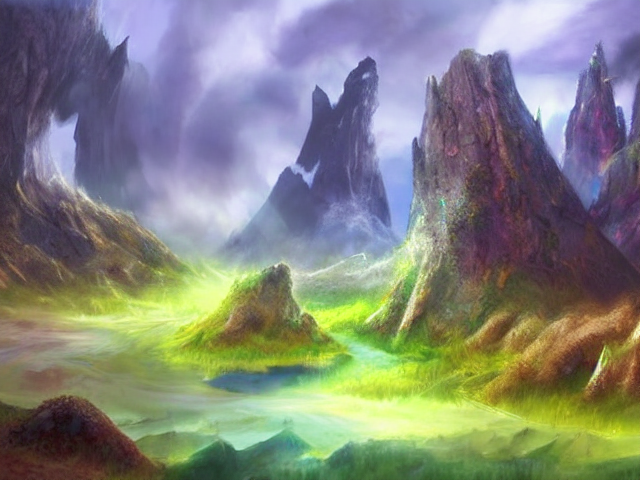

In [ ]:
imgs[0]

# Fine-tuning with Textual Inversion

Quickly "teach" a new word to the text model so that its embeddings are close to some specific type of visual representation. This is achieved by adding a new token to the vocabulary, freezing the weights of all the models except the text encoder, and train with a few representative images.

Hugging Face Space for fine-tuning: https://huggingface.co/sd-concepts-library/indian-watercolor-portraits

Below are the steps to add a trained token to the vocabulary and make it work with the pre-trained Stable Diffusion model.

## Load pipeline

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16).to("cuda")
#pipe.enable_attention_slicing()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Load trained embeddings for the new token

In [ ]:
embeds_url = "https://huggingface.co/sd-concepts-library/indian-watercolor-portraits/resolve/main/learned_embeds.bin"
embeds_path = FastDownload().download(embeds_url)
embeds_dict = torch.load(str(embeds_path), map_location='cpu')

## Add new token to tokenizer

In [ ]:
# Append the new token to pipeline
new_token, embeds = next(iter(embeds_dict.items()))
new_token

'<watercolor-portrait>'

In [ ]:
tokenizer = pipe.tokenizer
assert tokenizer.add_tokens(new_token) == 1, "Token exists already!"

## Add trained embeddings to the embeddings table

In [ ]:
text_encoder = pipe.text_encoder
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

In [ ]:
new_token_id = tokenizer.convert_tokens_to_ids(new_token)
embeds = embeds.to(text_encoder.dtype)
text_encoder.get_input_embeddings().weight.data[new_token_id] = embeds

## Make inference

In [ ]:
prompt = f"Woman sitting in the style of {new_token}"
imgs = pipe(prompt).images

  0%|          | 0/50 [00:00<?, ?it/s]

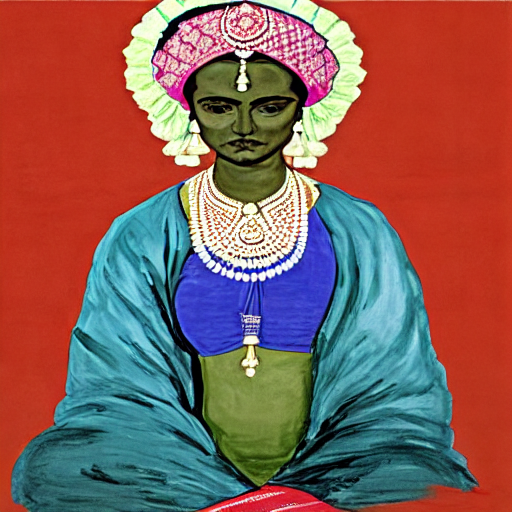

In [ ]:
imgs[0]